## Sales Forecasting Challenge - Feature Engineering and Modeling

In [1]:
# import all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [2]:
# read csv file and store it into a dataframe
df = pd.read_csv("2. train_sales_forecast.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,25037.08,False
1,1,1,2010-02-12,46247.44,True
2,1,1,2010-02-19,41783.43,False
3,1,1,2010-02-26,19491.18,False
4,1,1,2010-03-05,21926.49,False


#### Splitting the dataset:
In time series we perform temporal splitting. <br>
The dataset contains data from Feb 2010 to Apr 2012. I will use last 6 months (3 + 3) data for validation and test <br>
train data -> upto October 2011 <br>
validation data -> November 2011 to January 2012 <br>
test data -> February 2012 to April 2012

In [3]:
df_train = df[df.Date <= pd.to_datetime("2011-10-31")].reset_index(drop=True)
df_val = df[(df.Date >= pd.to_datetime("2011-11-01")) & (df.Date <= pd.to_datetime("2012-01-31"))].reset_index(drop=True)
df_test = df[(df.Date >= pd.to_datetime("2012-02-01")) & (df.Date <= pd.to_datetime("2012-04-30"))].reset_index(drop=True)

df_train.shape, df_val.shape, df_test.shape

((65332, 5), (9379, 5), (9345, 5))

In [4]:
df_train.Date.min(), df_train.Date.max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2011-10-28 00:00:00'))

In [5]:
df_val.Date.min(), df_val.Date.max()

(Timestamp('2011-11-04 00:00:00'), Timestamp('2012-01-27 00:00:00'))

In [6]:
df_test.Date.min(), df_test.Date.max()

(Timestamp('2012-02-03 00:00:00'), Timestamp('2012-04-27 00:00:00'))

In [7]:
def impute_missing_rows(df):
    """
    This function imputes missing rows to the dataframe to make it evenly spaned.

    Parameters:
    df: The pandas DataFrame object

    Returns:
    df: The pandas DataFrame object after imputation
    """
    print(f"Shape of dataframe before imputation: {df.shape}")
    # get minimum and maximum dates from the entire dataframe
    end_date = df.Date.max()
    start_date = df.Date.min()
    # get all the unique stores in the dataframe
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        # get all the departments from that store
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            # start_date = df_store_dept.Date.min()
            current_date = start_date
            while current_date <= end_date:
                # if a date is not present, impute it with Zero sales
                if current_date not in df_store_dept.Date.values:
                    # print([store_no, dept_no, current_date])
                    try:
                        # get the holiday information of the missing date from the entire df
                        is_holiday = df[df.Date == current_date]['IsHoliday'].values[0]
                    except:
                        print("Date not present in the entire dataframe, considering False")
                        is_holiday = False
                    df.loc[len(df)] = [store_no, dept_no, current_date, 0, is_holiday]
                current_date += timedelta(days=7)
    print(f"Shape of dataframe after imputation: {df.shape}")
    return df

In [8]:
def preprocess_dataframe(df):
    """
    This function preprocess the data before training.

    Parameters:
    df: The pandas DataFrame object

    Returns:
    df: The pandas DataFrame object after preprocessing
    """
    # impute missing rows in the dataframe
    df = impute_missing_rows(df)
    df.IsHoliday = df.IsHoliday.astype(int)
    return df

In [9]:
def filter_dataframe(df, store, dept):
    """
    This function filters dataframe based on store no and department.

    Parameters:
    df: The pandas DataFrame object
    store: Store number
    dept: Deparrtment number

    Returns:
    df: The pandas DataFrame object after filtering based on store and dept
    """
    df = df[(df['Store'] == store) & (df['Dept'] == dept)]
    return df

In [10]:
# preprocess the dataframe before statistical tests and training
df_train = preprocess_dataframe(df_train)

Shape of dataframe before imputation: (65332, 5)
Shape of dataframe after imputation: (69706, 5)


### Approach Discussion:
The dataset is a timeseries data with 10 stores and 81 departments present in the data that we saw in the EDA section. Our objective is to predict weekly sales for each department in each store. Every store_no and dept_no combination creates a series identifier in this dataset and every combination (store_no and dept_no combination) has a corresponding time series data. We need to forecast weekly sales for each department in each store i.e. for every series (store_no and dept_no combination) present in this data. <br>

As analyzed in the EDA section every series is not the same. Sales pattern of every store is different and within stores selling pattern of every department is also different. As seen in the EDA they have difference in magnitude and in pattern in some cases. So, we cannot generalize and prepare a single model based on the grouped and averaged i.e. generalized data. <br>

Considering the above scenario, I am going to extract every series from the entire data and fit a model on that data. This model will give forecast for the particular store and particular department of that store. The assumptions and hyperparameters will be same for all the models as it is not possible to manually analyze each and every series and train them separately. It will be decided on majority of the series from the dataset.The models will be trained on a series data and will be stored in a dictionary using a loop that will be further used for forecasting.

#### Analyze Stationarity of every series in the dataset:
To perform forecasting on a time series data it needs to be stationary. If not, we need to make it stationary before forecasting.

In [11]:
def adf_stationarity_test(time_series, significance_level=0.05):
    """
    This function checks stationarity of a time series data using ADF test
    Ho: It is non stationary
    H1: It is stationary

    If P-Value <= Significance Level:
        strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
    Else:
        weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary

    Parameters:
    time_series: time series data of which stationarity needs to be checked
    significance_level(optional): threshold of the hypothesis testing

    Returns: Tuple
    (Stationary, P-Value): True if the series is stationary else False, P-Value from ADF test
    """
    adf_result = adfuller(time_series)
    p_value = adf_result[1]
    
    if p_value <= significance_level:
        # strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
        return True, p_value
    else:
        # weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary
        return False, p_value

#### ADF Test:

In [12]:
def adf_test_entire_df(df, col_name, threshold=0.05):
    """
    This function performs ADF test for every series present in the dataset.

    Parameters:
    df: The pandas DataFrame object
    col_name: column on which stationarity will be checked
    threshold(optional): Significance level for ADF test

    Returns:
    df: The pandas DataFrame object consistinf of Store, Dept, IsStationary and p-value
    """
    adf_test_result_df = pd.DataFrame(columns=['Store', 'Dept', 'IsStationary', 'p_value'])
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values('Date')
            stationary, p_value = adf_stationarity_test(df_store_dept[col_name], threshold)
            adf_test_result_df.loc[len(adf_test_result_df)] = [store_no, dept_no, stationary, p_value]
    return adf_test_result_df

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# check stationarity of every series present in the train data 
adf_test_result_df = adf_test_entire_df(df_train, 'Weekly_Sales')
adf_test_result_df.head()

,Store,Dept,IsStationary,p_value
0,1,1,True,1.149744e-07
1,1,2,True,4.556657e-14
2,1,3,True,4.580639e-03
3,1,4,True,7.411068e-03
4,1,5,True,1.480275e-02


In [15]:
# check how many are stationary and how many are not
adf_test_result_df.IsStationary.value_counts()

IsStationary
True     545
False    221
Name: count, dtype: int64

#### Observation:
545 number of series is stationary and 221 series are not stationary.

#### Differencing - 1st Order:

In [16]:
# perform first difference and then ADF test
df_train_stationarity_check = df_train.copy()
df_train_stationarity_check['Weekly_Sales_First_Difference'] = df_train_stationarity_check['Weekly_Sales'] - df_train_stationarity_check['Weekly_Sales'].shift(1)
df_train_stationarity_check = df_train_stationarity_check.dropna()
df_train_stationarity_check.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_First_Difference
1,1,1,2010-02-12,46247.44,1,21210.36
2,1,1,2010-02-19,41783.43,0,-4464.01
3,1,1,2010-02-26,19491.18,0,-22292.25
4,1,1,2010-03-05,21926.49,0,2435.31
5,1,1,2010-03-12,21138.44,0,-788.05


In [17]:
# perform ADF test on first differenced data
adf_test_result_df_firstdiff = adf_test_entire_df(df_train_stationarity_check, 'Weekly_Sales_First_Difference')
adf_test_result_df_firstdiff.head()

,Store,Dept,IsStationary,p_value
0,1,1,True,3.177968e-11
1,1,2,True,6.586142e-07
2,1,3,True,9.892960e-17
3,1,4,True,8.277073e-20
4,1,5,True,2.459392e-06


In [18]:
# check how many are stationary and how many are not
adf_test_result_df_firstdiff.IsStationary.value_counts()

IsStationary
True     754
False     12
Name: count, dtype: int64

#### Observation:
So, after first differencing, there are 754 number of series is stationary and only 12 series are not stationary. There is a huge improvent in first differencing.

In [19]:
# take some random store_no and dept_no combinations and plot them to observe stationarity
def plot_original_and_differenced_data(df, col1, col2):
    # Create a figure and two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Plot the first graph
    ax1.plot(df['Date'], df[col1], label=col1)
    ax1.set_title(f'Plotting of {col1}')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(col1)
    ax1.legend()
    
    # Plot the second graph
    ax2.plot(df['Date'], df[col2], label=col2, color='orange')
    ax2.set_title(f'Plotting of {col2}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel(col2)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

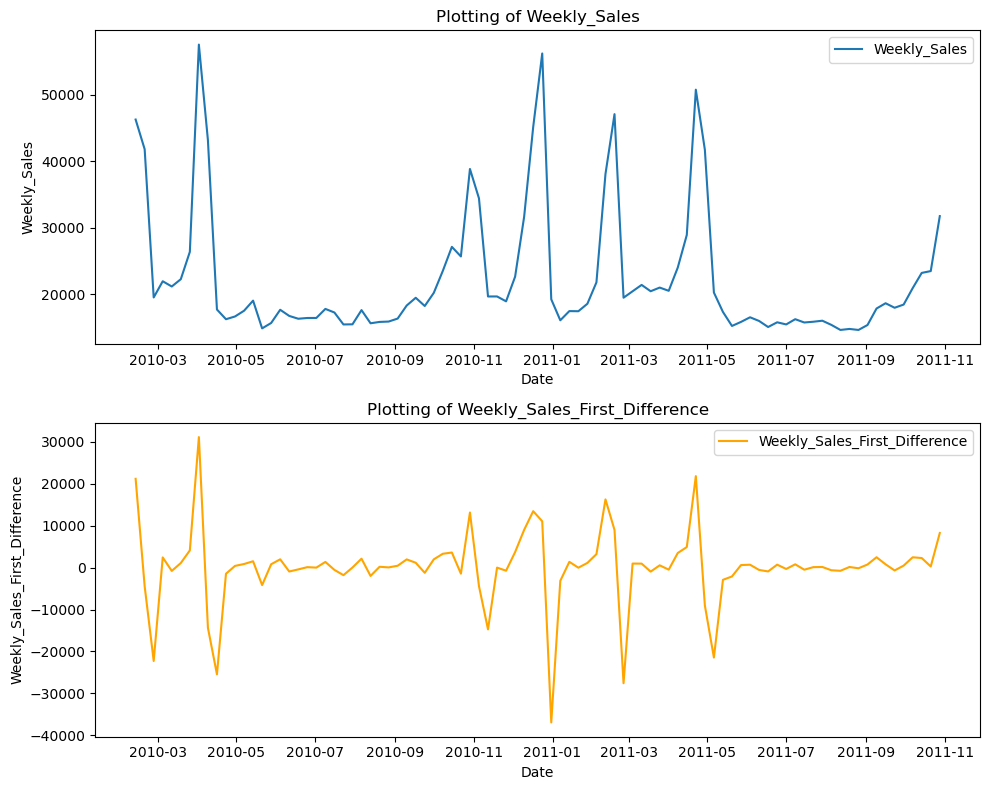

In [20]:
df_train_stationarity_check_1_1 = filter_dataframe(df_train_stationarity_check, 1, 1)
plot_original_and_differenced_data(df_train_stationarity_check_1_1, 'Weekly_Sales', 'Weekly_Sales_First_Difference')

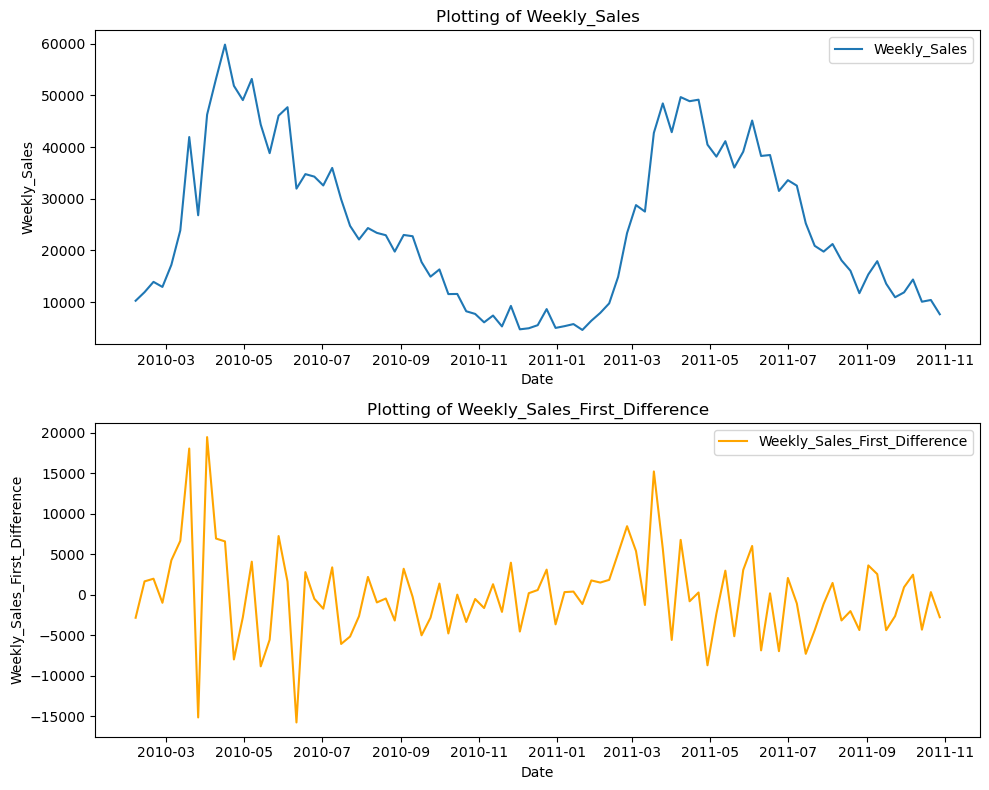

In [21]:
df_train_stationarity_check_1_16 = filter_dataframe(df_train_stationarity_check, 1, 16)
plot_original_and_differenced_data(df_train_stationarity_check_1_16, 'Weekly_Sales', 'Weekly_Sales_First_Difference')

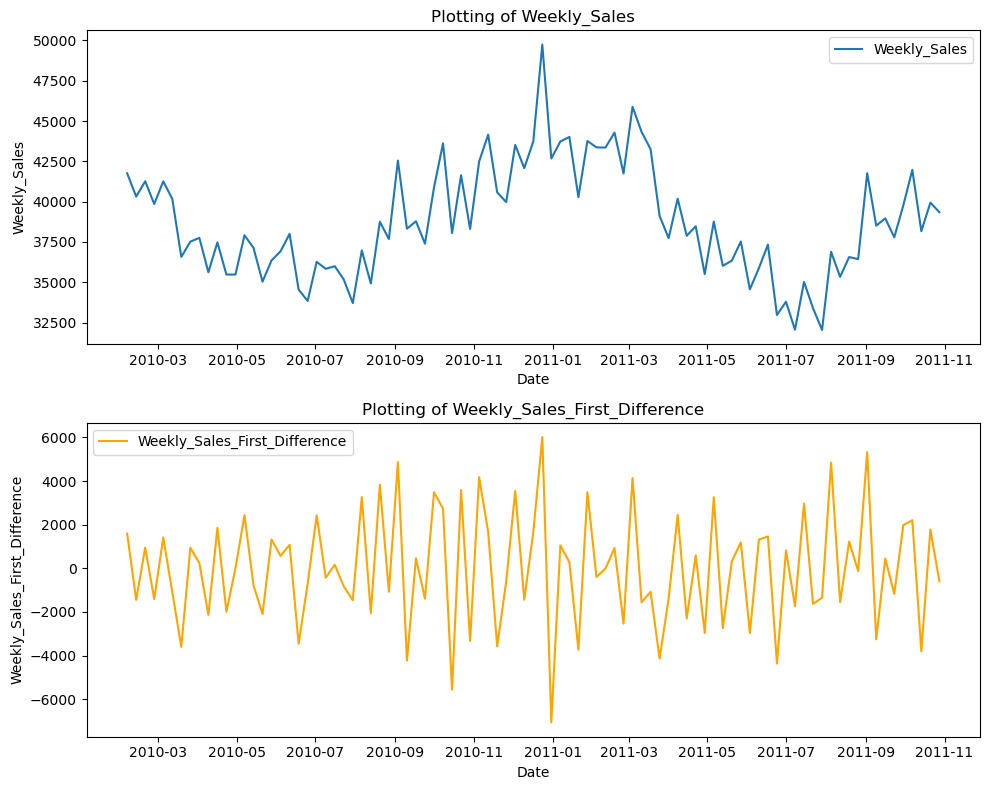

In [22]:
df_train_stationarity_check_10_40 = filter_dataframe(df_train_stationarity_check, 10, 40)
plot_original_and_differenced_data(df_train_stationarity_check_10_40, 'Weekly_Sales', 'Weekly_Sales_First_Difference')

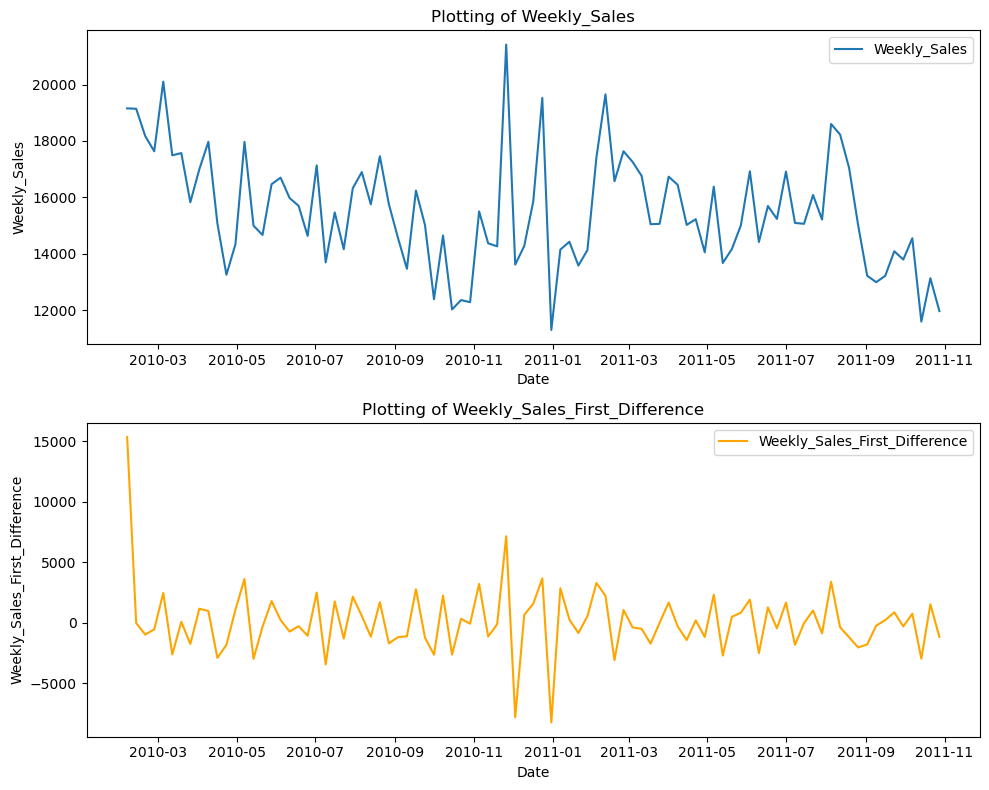

In [23]:
df_train_stationarity_check_5_20 = filter_dataframe(df_train_stationarity_check, 5, 20)
plot_original_and_differenced_data(df_train_stationarity_check_5_20, 'Weekly_Sales', 'Weekly_Sales_First_Difference')

#### Observation:
We can visually observe that the data has become stationary with differencing = 1

#### Differencing - 2nd Order:

In [24]:
# perform first difference and then ADF test
df_train_stationarity_check['Weekly_Sales_Second_Difference'] = df_train_stationarity_check['Weekly_Sales_First_Difference'] - df_train_stationarity_check['Weekly_Sales_First_Difference'].shift(1)
df_train_stationarity_check = df_train_stationarity_check.dropna()
df_train_stationarity_check.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_First_Difference,Weekly_Sales_Second_Difference
2,1,1,2010-02-19,41783.43,0,-4464.01,-25674.37
3,1,1,2010-02-26,19491.18,0,-22292.25,-17828.24
4,1,1,2010-03-05,21926.49,0,2435.31,24727.56
5,1,1,2010-03-12,21138.44,0,-788.05,-3223.36
6,1,1,2010-03-19,22236.62,0,1098.18,1886.23


In [25]:
# perform ADF test on second differenced data
adf_test_result_df_seconddiff = adf_test_entire_df(df_train_stationarity_check, 'Weekly_Sales_Second_Difference')
adf_test_result_df_seconddiff.head()

,Store,Dept,IsStationary,p_value
0,1,1,True,3.445721e-08
1,1,2,True,4.279174e-08
2,1,3,True,1.916755e-06
3,1,4,True,1.974501e-14
4,1,5,True,1.673598e-07


In [26]:
# check how many are stationary and how many are not
adf_test_result_df_seconddiff.IsStationary.value_counts()

IsStationary
True    766
Name: count, dtype: int64

#### Observation:
All the series has become stationary after 2nd order differencing

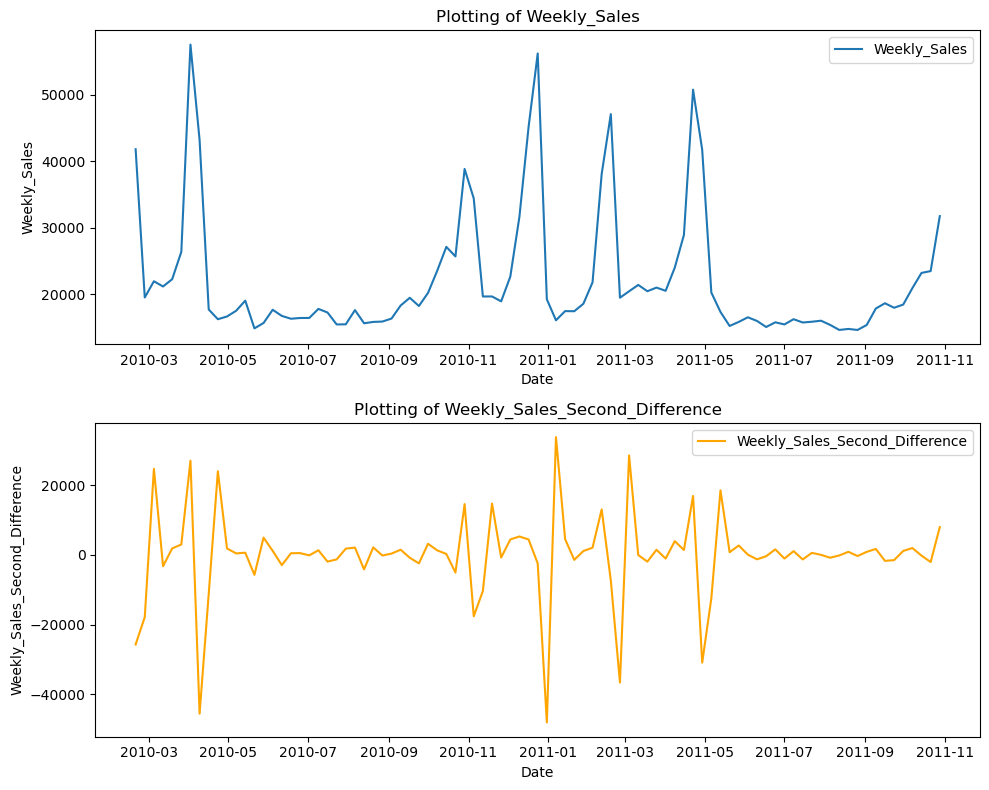

In [27]:
df_train_stationarity_check_1_1 = filter_dataframe(df_train_stationarity_check, 1, 1)
plot_original_and_differenced_data(df_train_stationarity_check_1_1, 'Weekly_Sales', 'Weekly_Sales_Second_Difference')

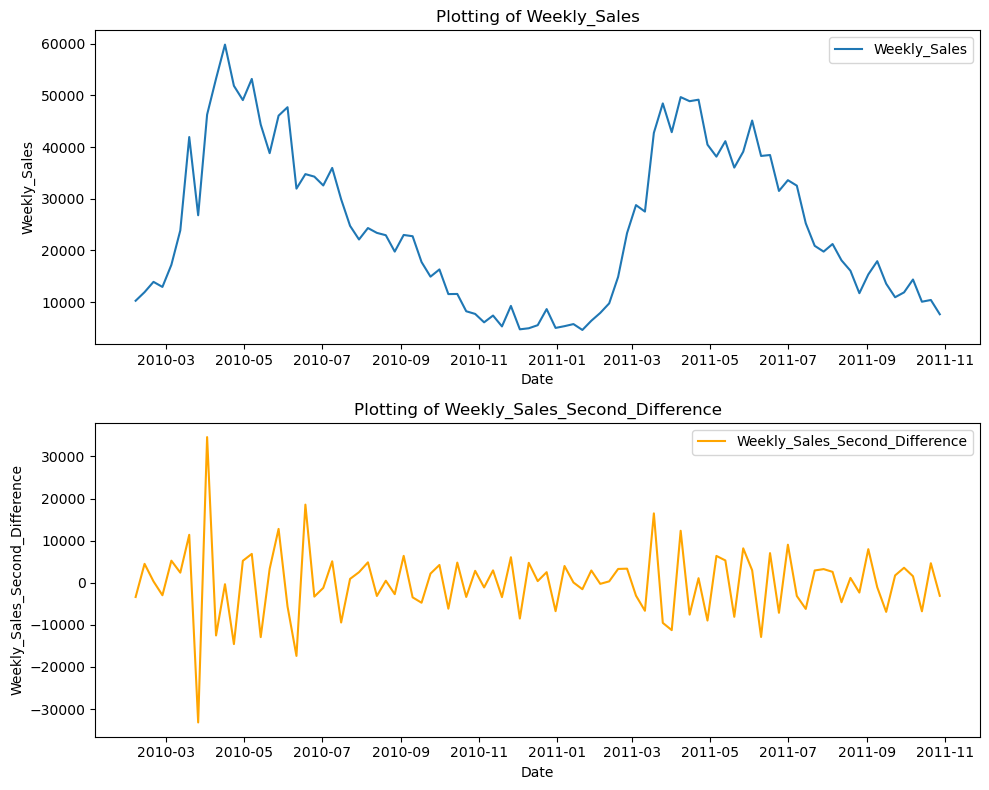

In [28]:
df_train_stationarity_check_1_16 = filter_dataframe(df_train_stationarity_check, 1, 16)
plot_original_and_differenced_data(df_train_stationarity_check_1_16, 'Weekly_Sales', 'Weekly_Sales_Second_Difference')

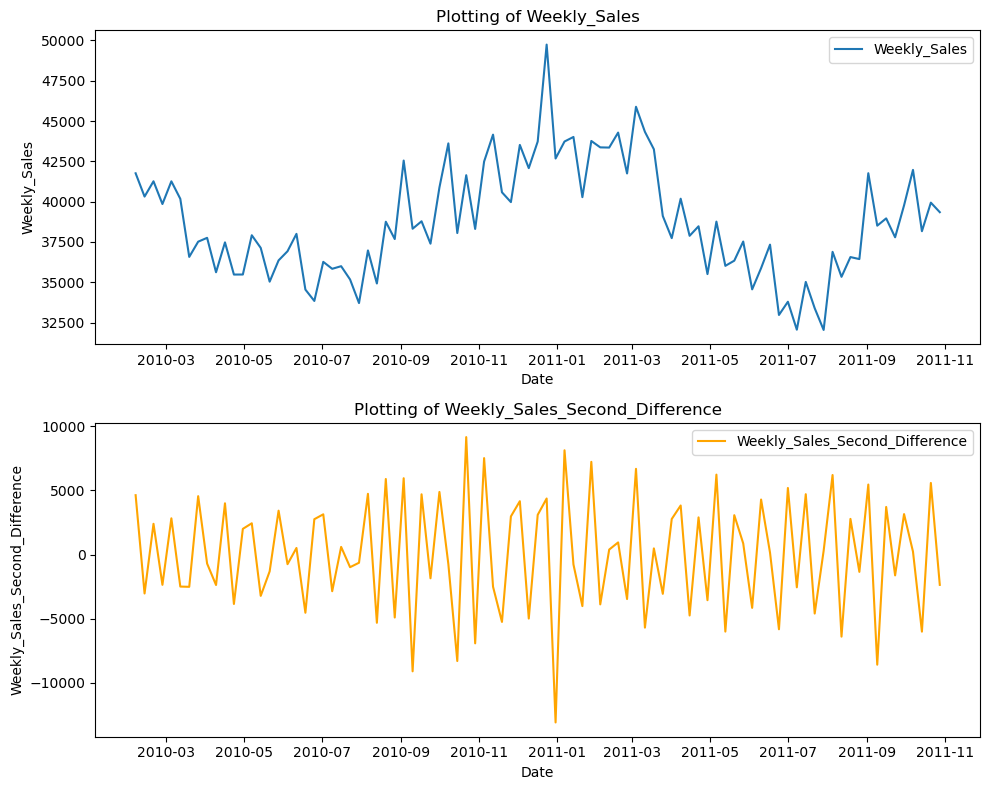

In [29]:
df_train_stationarity_check_10_40 = filter_dataframe(df_train_stationarity_check, 10, 40)
plot_original_and_differenced_data(df_train_stationarity_check_10_40, 'Weekly_Sales', 'Weekly_Sales_Second_Difference')

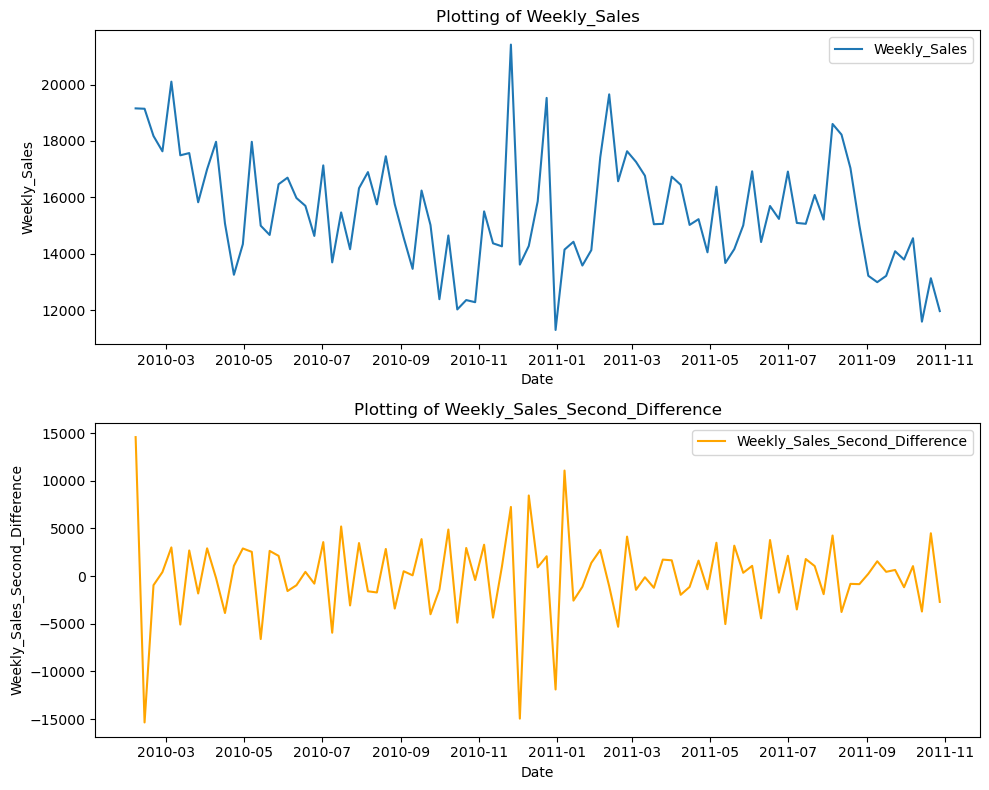

In [30]:
df_train_stationarity_check_5_20 = filter_dataframe(df_train_stationarity_check, 5, 20)
plot_original_and_differenced_data(df_train_stationarity_check_5_20, 'Weekly_Sales', 'Weekly_Sales_Second_Difference')

#### Observation:
We can visually observe that the data has become stationary with differencing = 2

#### Seasonality Check - Yearly:

In [31]:
# perform first difference and then ADF test
df_train_stationarity_check = df_train.copy()
df_train_stationarity_check['Weekly_Sales_Yearly_First_Difference'] = df_train_stationarity_check['Weekly_Sales'] - df_train_stationarity_check['Weekly_Sales'].shift(52)
df_train_stationarity_check = df_train_stationarity_check.dropna()
df_train_stationarity_check.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_Yearly_First_Difference
52,1,1,2011-02-04,21763.62,0,-3273.46
53,1,1,2011-02-11,38058.30,1,-8189.14
54,1,1,2011-02-18,47057.46,0,5274.03
55,1,1,2011-02-25,19451.29,0,-39.89
56,1,1,2011-03-04,20419.42,0,-1507.07


In [32]:
# perform ADF test on second differenced data
adf_test_result_df_yearly_firstdiff = adf_test_entire_df(df_train_stationarity_check, 'Weekly_Sales_Yearly_First_Difference')
adf_test_result_df_yearly_firstdiff.head()

,Store,Dept,IsStationary,p_value
0,1,1,False,0.112357
1,1,2,False,0.891901
2,1,3,False,0.455759
3,1,4,False,0.355227
4,1,5,True,0.000665


In [33]:
# check how many are stationary and how many are not
adf_test_result_df_yearly_firstdiff.IsStationary.value_counts()

IsStationary
False    495
True     271
Name: count, dtype: int64

#### Observation:
Yearly differencing does not make much of the series stationary. It makes the stationarity more worse, originally was 545 and after seasonal difference 495 series are stationary.

#### Seasonality Check - Quaterly:

In [34]:
# perform first difference and then ADF test
df_train_stationarity_check = df_train.copy()
df_train_stationarity_check['Weekly_Sales_Quaterly_First_Difference'] = df_train_stationarity_check['Weekly_Sales'] - df_train_stationarity_check['Weekly_Sales'].shift(13)
df_train_stationarity_check = df_train_stationarity_check.dropna()
df_train_stationarity_check.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_Quaterly_First_Difference
13,1,1,2010-05-07,17492.59,0,-7544.49
14,1,1,2010-05-14,19012.23,0,-27235.21
15,1,1,2010-05-21,14839.77,0,-26943.66
16,1,1,2010-05-28,15650.80,0,-3840.38
17,1,1,2010-06-04,17637.39,0,-4289.10


In [35]:
# perform ADF test on second differenced data
adf_test_result_df_quaterly_firstdiff = adf_test_entire_df(df_train_stationarity_check, 'Weekly_Sales_Quaterly_First_Difference')
adf_test_result_df_quaterly_firstdiff.head()

,Store,Dept,IsStationary,p_value
0,1,1,False,0.069278
1,1,2,True,0.004466
2,1,3,False,0.064700
3,1,4,True,0.018021
4,1,5,True,0.002124


In [36]:
# check how many are stationary and how many are not
adf_test_result_df_quaterly_firstdiff.IsStationary.value_counts()

IsStationary
True     602
False    164
Name: count, dtype: int64

#### Observation:
Quaterly seasonal differencing makes it little better. Originally 545 to 602 after quaterly differencing.

In [37]:
def plot_acf_pacf(df, col):
    """
    This function plots ACF and PACF plot for a time series data.

    Parameters:
    df: The pandas DataFrame object
    col: column on which acf pacf will be plotted
    """
    fig = plt.figure(figsize=(12, 8))
    
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df[col],lags=40,ax=ax1)
    
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df[col],lags=40,ax=ax2)
    plt.show()

In [38]:
df_train_stationarity_check = df_train.copy()
df_train_stationarity_check['Weekly_Sales_First_Difference'] = df_train_stationarity_check['Weekly_Sales'] - df_train_stationarity_check['Weekly_Sales'].shift(1)
df_train_stationarity_check = df_train_stationarity_check.dropna()
df_train_stationarity_check.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Weekly_Sales_First_Difference
1,1,1,2010-02-12,46247.44,1,21210.36
2,1,1,2010-02-19,41783.43,0,-4464.01
3,1,1,2010-02-26,19491.18,0,-22292.25
4,1,1,2010-03-05,21926.49,0,2435.31
5,1,1,2010-03-12,21138.44,0,-788.05


In [39]:
def plot_acf_pacf_multiple_series(df, series_identifier_list, col_name):
    # this function plots acf pacf plots for the series combination present in series_identifier_list
    for ele in series_identifier_list:
        filtered_dataframe = filter_dataframe(df_train_stationarity_check, ele[0], ele[1])
        print(f"Plotting ACF and PACF plots for Store: {ele[0]} and Dept: {ele[1]}")
        plot_acf_pacf(filtered_dataframe, col_name)

Plotting ACF and PACF plots for Store: 1 and Dept: 4


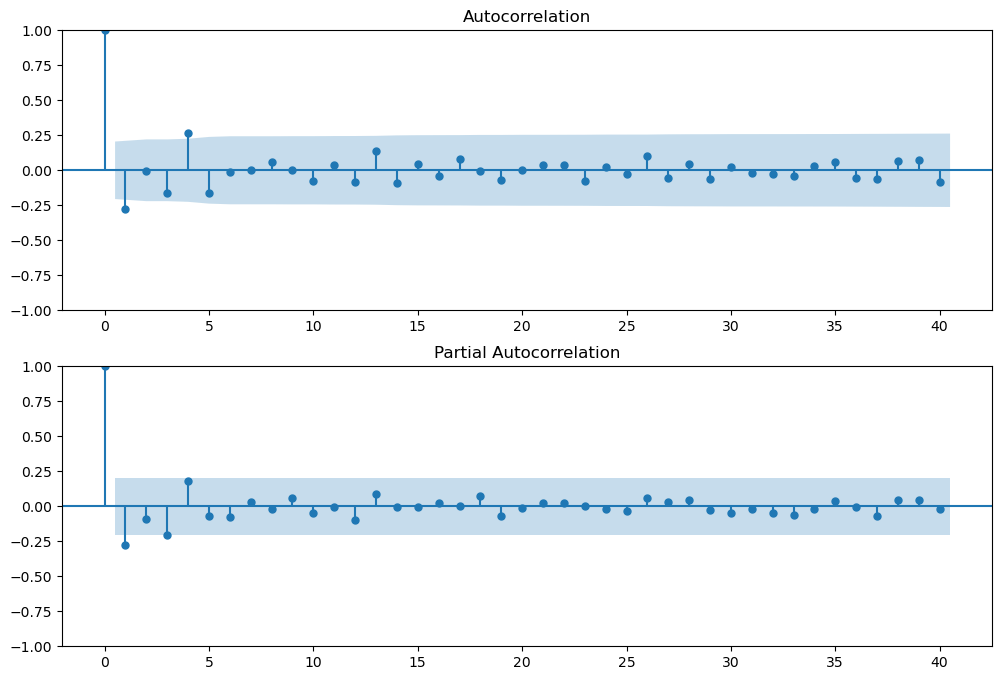

Plotting ACF and PACF plots for Store: 1 and Dept: 12


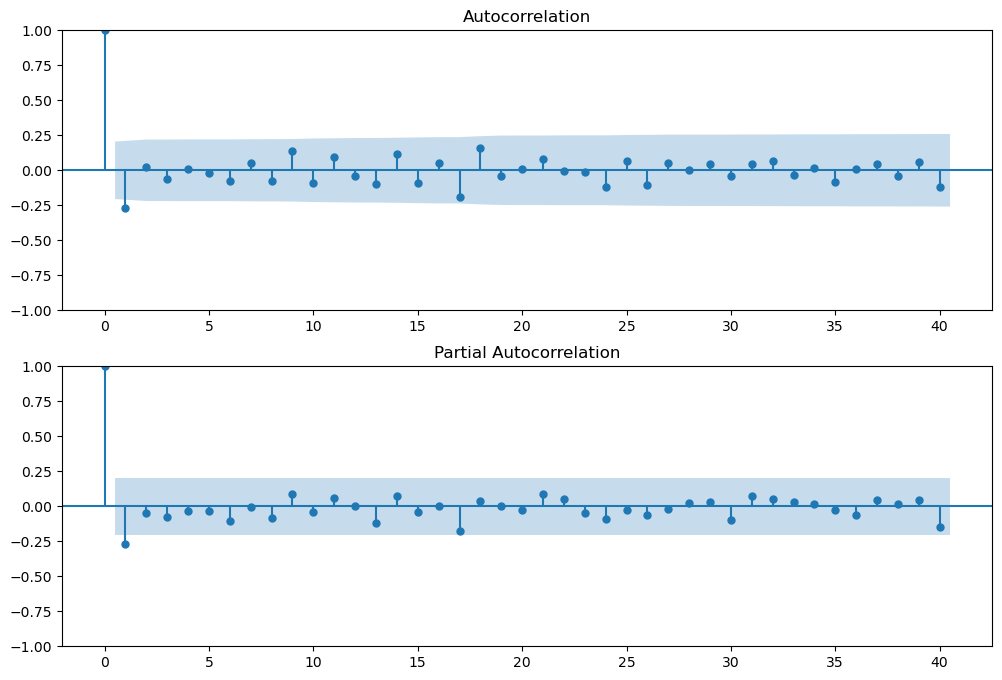

Plotting ACF and PACF plots for Store: 5 and Dept: 18


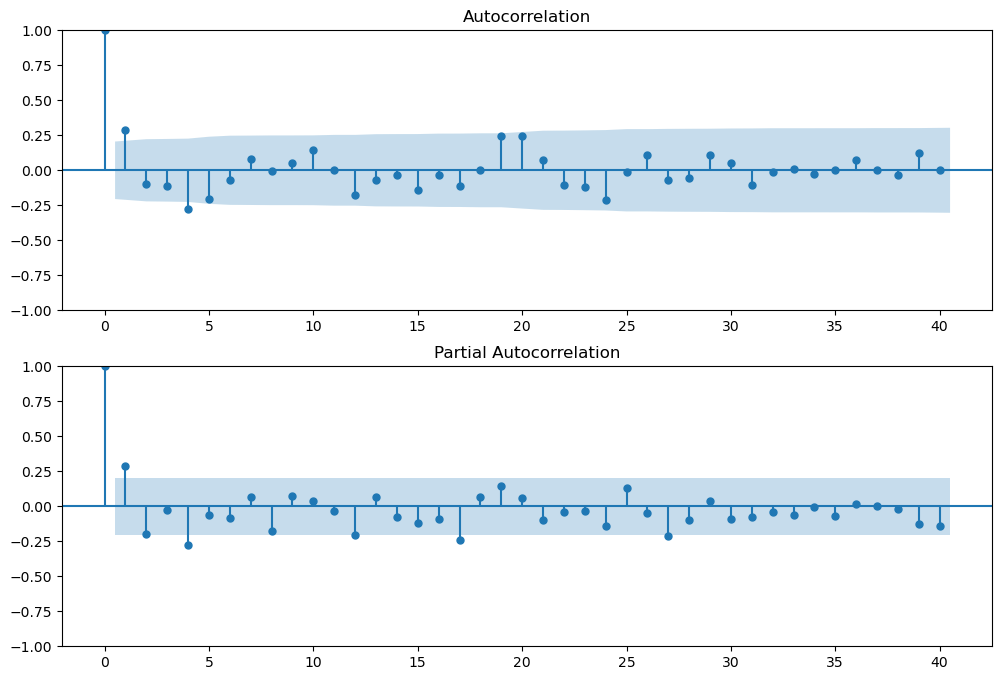

Plotting ACF and PACF plots for Store: 8 and Dept: 44


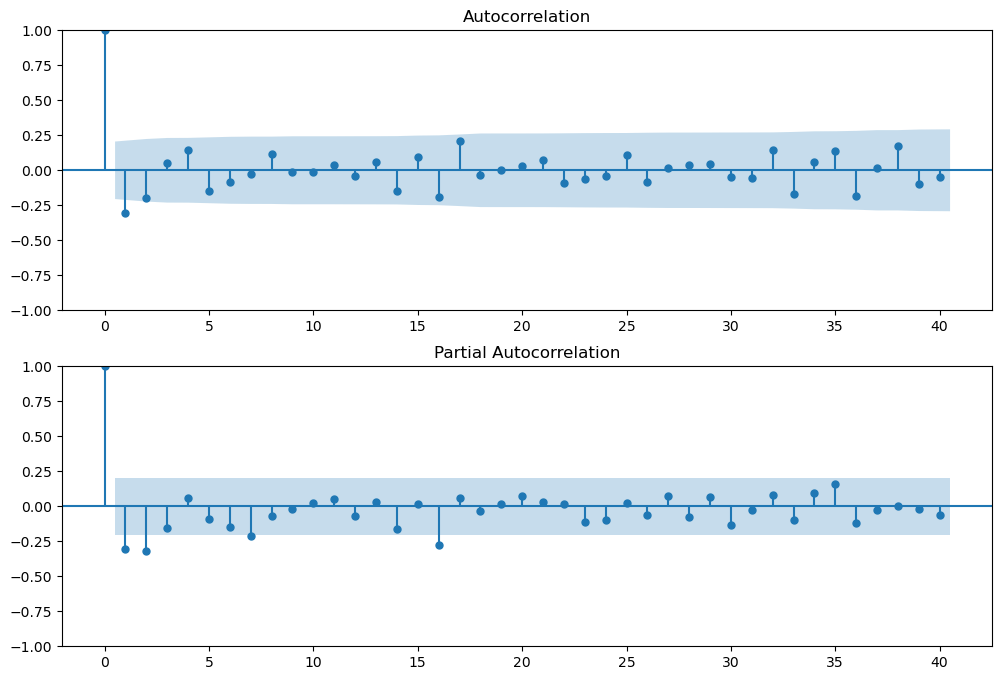

In [40]:
series_identifier_list = [(1, 4), (1, 12), (5, 18), (8, 44)]
plot_acf_pacf_multiple_series(df_train_stationarity_check, series_identifier_list, 'Weekly_Sales_First_Difference')

#### Observation:
1. q value: We get it from ACF plot. There are many series we will try 1 and 2 from the above ACF plots.
2. p value: We get it from PACF plot, We will try 1 and 2 from the above PACF plots.

#### Error Metric - MAPE

In [41]:
# this method computes MAPE for a dataframe based on actual and forecasted value
def mean_absolute_percentage_error(df):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)

    Parameters:
    df: dataframe object

    Returns:
    float: MAPE value
    """
    df = df.dropna()
    y_true = df['Weekly_Sales']
    y_pred = df['Weekly_Sales_Predicted']
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Exclude cases where y_true is zero to avoid division by zero
    non_zero_indices = y_true != 0
    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    
    if len(y_true_non_zero) == 0:
        raise ValueError("All true values are zero, MAPE cannot be computed.")
    
    return np.mean(np.abs((y_true_non_zero - y_pred_non_zero) / y_true_non_zero))

## Data Modeling:

#### ARIMA Model without Exogenous Variable:

In [98]:
def fit_arima_model(df, order):
    """
    This function fits ARIMA model

    Parameters:
    df: dataframe object
    order: (p, d, q)

    Returns:
    fitted model object
    """
    # Ensure the data is sorted by date
    df = df.sort_values(by='Date')
     # Set the date as index and set the frequency Weekly-Friday (Dates are of Friday)
    df = df.set_index('Date').asfreq('W-FRI')
   
    # Fit the ARIMA model
    model = ARIMA(df['Weekly_Sales'], order=order)
    model_fit = model.fit()
    
    return model_fit

In [43]:
def train_arima_model(df, order):
    """
    This function trains every series of the dataframe.
    Parameters:
    df: dataframe object
    order: (p, d, q)

    Returns:
    Dictionary containing fitted models with key tuple(store, dept) and value model object
    """
    models_dict = {}
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            try:
                model_fit = fit_arima_model(df_store_dept, order)
                models_dict[(store_no, dept_no)] = model_fit
            except Exception as e:
                print(f'Failed to fit ARIMA model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [44]:
def validate_arima_model(df_train, df_val, models_dict, forecast_steps):
    predicted_arima_df = pd.DataFrame()
    for store_no in df_train.Store.unique():
        df_store = df_train[df_train.Store == store_no]
        for dept_no in df_store.Dept.unique():
            forecast = models_dict[(store_no, dept_no)].get_forecast(steps=forecast_steps)
            forecast_df = forecast.summary_frame()
            forecast_df = forecast_df[['mean']]
            forecast_df['Store'] = store_no
            forecast_df['Dept'] = dept_no
            predicted_arima_df  = pd.concat([predicted_arima_df, forecast_df], ignore_index=False)
    predicted_arima_df = predicted_arima_df.reset_index()
    predicted_arima_df = predicted_arima_df.rename(columns={'index': 'Date', 'mean': 'Weekly_Sales_Predicted'})
    predicted_arima_df = predicted_arima_df.reset_index(drop=True)

    # merge the predicted forecast with df_val
    df_merged_predicted_sales = pd.merge(df_val, predicted_arima_df, on=['Store', 'Dept', 'Date'], how='left')
    return df_merged_predicted_sales

#### Hyperparameters for ARIMA and SARIMAX model:
1. d value: We get it from the no of differencing used to make the series stationary. 1st differencing made most of the stationary and 2nd differencing made all the data stationary. So, we will try d = 1 and 2.
2. q value: We get it from ACF plot. There are many series we will try 1 and 2 from the above ACF plots.
3. p value: We get it from PACF plot, We will try 1 and 2 from the above PACF plots.

#### Perform a search operation and validate on the validation based on MAPE score to find the best parameter

In [45]:
# grid search for pdq
pdq_combinations = [(1,1,1), (2,1,2), (1,2,1), (2,2,2)]
mape_score_list = []
for pdq in pdq_combinations:
    arima_trained_models_dict = train_arima_model(df_train, order=pdq)
    validation_forecasted_df = validate_arima_model(df_train, df_val, arima_trained_models_dict, forecast_steps=13)
    mape_score = round(mean_absolute_percentage_error(validation_forecasted_df), 4)
    print(f"MAPE Score for pdq={pdq} is {mape_score}")
    mape_score_list.append(mape_score)

MAPE Score for pdq=(1, 1, 1) is 0.3808
MAPE Score for pdq=(2, 1, 2) is 0.3835
MAPE Score for pdq=(1, 2, 1) is 0.5078
MAPE Score for pdq=(2, 2, 2) is 0.4523


In [46]:
min_value_arima_mape = min(mape_score_list)
mape_score_array_arima = np.array(mape_score_list)
min_index_arima = np.argmin(mape_score_array_arima)
best_pdq_arima = pdq_combinations[min_index_arima]
print(f"Best MAPE score = {min_value_arima_mape} for pdq = {best_pdq_arima}")

Best MAPE score = 0.3808 for pdq = (1, 1, 1)


#### Now train the ARIMA model with best hyperparamaters with train + val data to predict test data

In [47]:
df_train_val = df[df.Date <= pd.to_datetime("2012-01-31")].reset_index(drop=True)
df_train_val.Date.min(), df_train_val.Date.max()
df_train_val = preprocess_dataframe(df_train_val)

Shape of dataframe before imputation: (74711, 5)
Shape of dataframe after imputation: (80808, 5)


In [48]:
arima_trained_models_dict = train_arima_model(df_train_val, order=(1,1,1))
test_forecasted_arima_df = validate_arima_model(df_train_val, df_test, arima_trained_models_dict, forecast_steps=13)
mape_score_arima_test = round(mean_absolute_percentage_error(test_forecasted_arima_df), 4)
print(f"Test Score for ARIMA model is {mape_score_arima_test}")

Test Score for ARIMA model is 4.7725


In [99]:
!pip install beautifultable
from beautifultable import BeautifulTable

In [50]:
table = BeautifulTable() 
table.column_headers= ["Model Name", "Validation MAPE", "Test MAPE"]
table.append_row(["ARIMA", "0.3808", "4.7725"])
print(table)

+------------+-----------------+-----------+
| Model Name | Validation MAPE | Test MAPE |
+------------+-----------------+-----------+
|   ARIMA    |      0.381      |   4.772   |
+------------+-----------------+-----------+


#### Plot Original and Predicted Sales for Test Data

In [72]:
def plot_original_and_predicted_data(df, col1='Weekly_Sales', col2='Weekly_Sales_Predicted'):
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='Date', y=col1, label='Original')
    sns.lineplot(data=df, x='Date', y=col2, label='Predicted')
    
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.title('Original vs Predicted Weekly Sales Forecasts')
    plt.legend()
    plt.show()

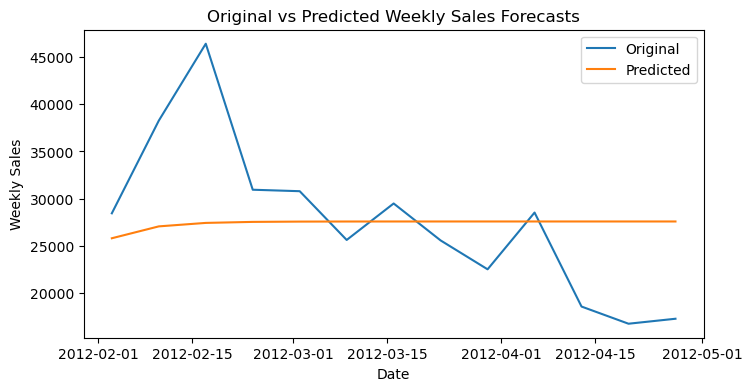

In [73]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

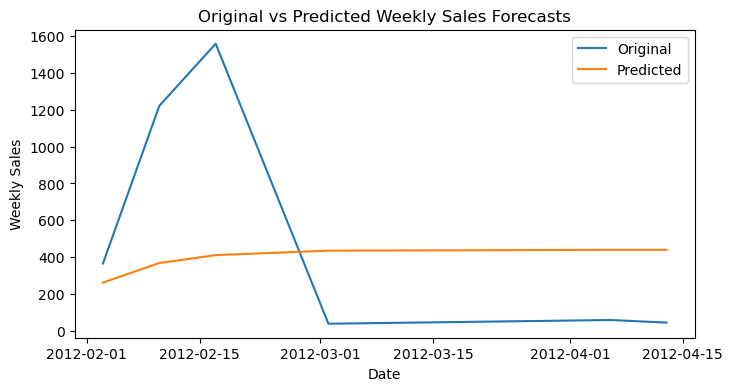

In [79]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

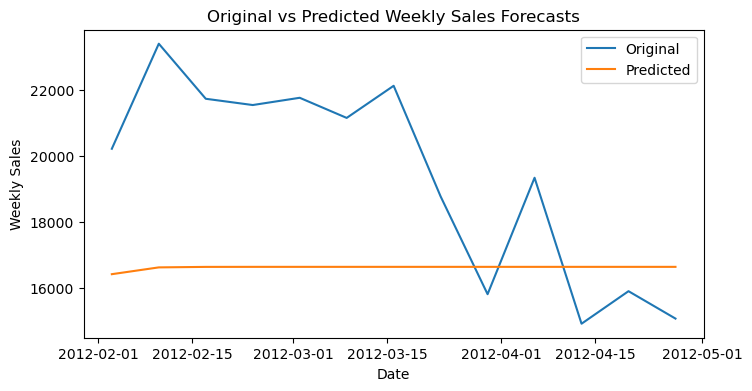

In [82]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

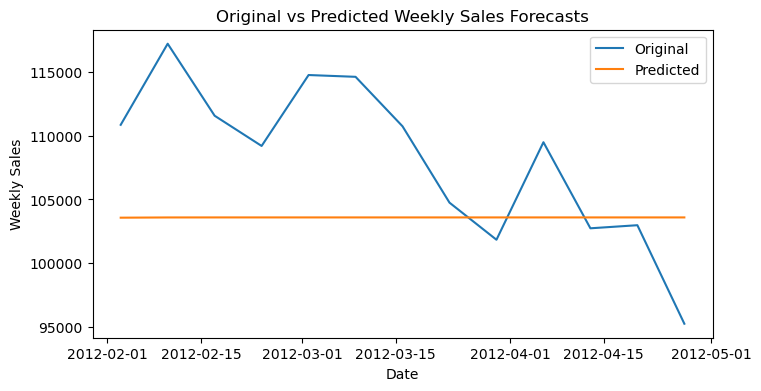

In [85]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_arima_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

#### SARIMAX Model without Exogenous Variable:

In [51]:
def fit_sarimax_model(df, order, seasonal_order):
    """
    This function fits SARIMAX model

    Parameters:
    df: dataframe object
    order: (p, d, q)
    seasonal_order = (p, d, q, s)

    Returns:
    fitted model object
    """
    # Ensure the data is sorted by date
    df = df.sort_values(by='Date')
     # Set the date as index and set the frequency Weekly-Friday (Dates are of Friday)
    df = df.set_index('Date').asfreq('W-FRI')
   
    # Fit the ARIMA model
    model = SARIMAX(df['Weekly_Sales'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    return model_fit

In [52]:
def train_sarimax_model(df, order, seasonal_order):
    """
    This function trains every series of the dataframe.
    Parameters:
    df: dataframe object
    order: (p, d, q)
    seasonal_order = (p, d, q, s)
    
    Returns:
    Dictionary containing fitted models with key tuple(store, dept) and value model object
    """
    models_dict = {}
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            try:
                model_fit = fit_sarimax_model(df_store_dept, order, seasonal_order)
                models_dict[(store_no, dept_no)] = model_fit
            except Exception as e:
                print(f'Failed to fit SARIMAX model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [53]:
def validate_sarimax_model(df_train, df_val, models_dict, forecast_steps):
    predicted_sarimax_df = pd.DataFrame()
    for store_no in df_train.Store.unique():
        df_store = df_train[df_train.Store == store_no]
        for dept_no in df_store.Dept.unique():
            forecast = models_dict[(store_no, dept_no)].get_forecast(steps=forecast_steps)
            forecast_df = forecast.summary_frame()
            forecast_df = forecast_df[['mean']]
            forecast_df['Store'] = store_no
            forecast_df['Dept'] = dept_no
            predicted_sarimax_df  = pd.concat([predicted_sarimax_df, forecast_df], ignore_index=False)
    predicted_sarimax_df = predicted_sarimax_df.reset_index()
    predicted_sarimax_df = predicted_sarimax_df.rename(columns={'index': 'Date', 'mean': 'Weekly_Sales_Predicted'})
    predicted_sarimax_df = predicted_sarimax_df.reset_index(drop=True)

    # merge the predicted forecast with df_val
    df_merged_predicted_sales = pd.merge(df_val, predicted_sarimax_df, on=['Store', 'Dept', 'Date'], how='left')
    return df_merged_predicted_sales

In [54]:
# considering quaterly seasonal order for sarimax, i.e. 13 weeks
sarimax_trained_models_dict = train_sarimax_model(df_train, order=(1,1,1), seasonal_order=(1,1,1,13))
validation_forecasted_sarimax_df = validate_sarimax_model(df_train, df_val, sarimax_trained_models_dict, forecast_steps=13)
mape_score_sarimax_val = round(mean_absolute_percentage_error(validation_forecasted_sarimax_df), 4)
print(f"Validation Score for SARIMAX model is {mape_score_sarimax_val}")

Validation Score for SARIMAX model is 0.4408


In [55]:
# considering monthly seasonal order for sarimax, i.e. 4 weeks
sarimax_trained_models_dict = train_sarimax_model(df_train, order=(1,1,1), seasonal_order=(1,1,1,4))
validation_forecasted_sarimax_df = validate_sarimax_model(df_train, df_val, sarimax_trained_models_dict, forecast_steps=13)
mape_score_sarimax_val = round(mean_absolute_percentage_error(validation_forecasted_sarimax_df), 4)
print(f"Validation Score for SARIMAX model is {mape_score_sarimax_val}")

Validation Score for SARIMAX model is 0.4169


In [56]:
# check the performance on test data after training on train + val data
# considering monthly seasonal order for sarimax, i.e. 4 weeks
sarimax_trained_models_dict = train_sarimax_model(df_train_val, order=(1,1,1), seasonal_order=(1,1,1,4))
test_forecasted_sarimax_df = validate_sarimax_model(df_train_val, df_test, sarimax_trained_models_dict, forecast_steps=13)
mape_score_sarimax_test = round(mean_absolute_percentage_error(test_forecasted_sarimax_df), 4)
print(f"Test Score for SARIMAX model is {mape_score_sarimax_test}")

Test Score for SARIMAX model is 12.1021


In [57]:
table.append_row(["SARIMAX", "0.4169", "12.1021"])
print(table)

+------------+-----------------+-----------+
| Model Name | Validation MAPE | Test MAPE |
+------------+-----------------+-----------+
|   ARIMA    |      0.381      |   4.772   |
+------------+-----------------+-----------+
|  SARIMAX   |      0.417      |  12.102   |
+------------+-----------------+-----------+


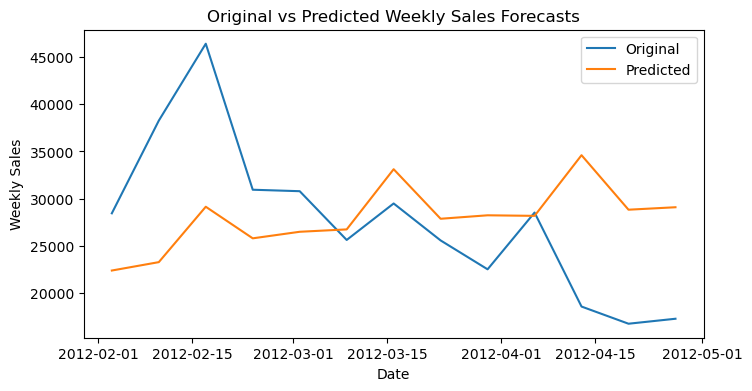

In [93]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

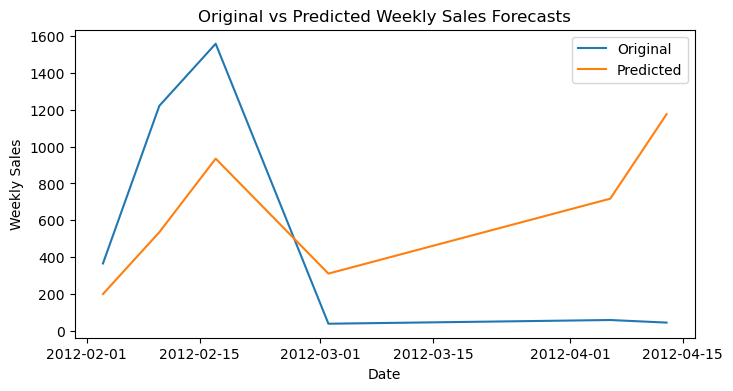

In [92]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

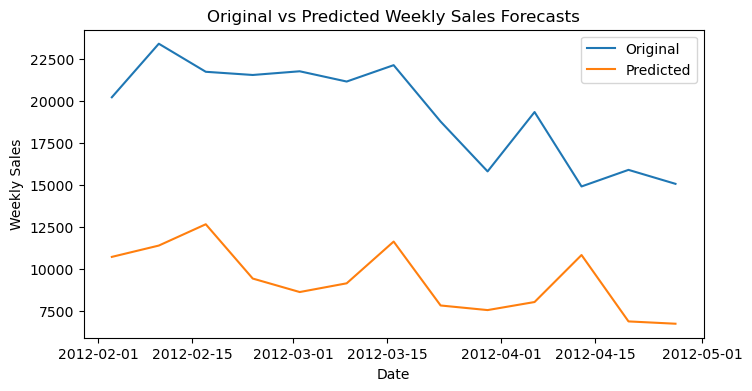

In [91]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

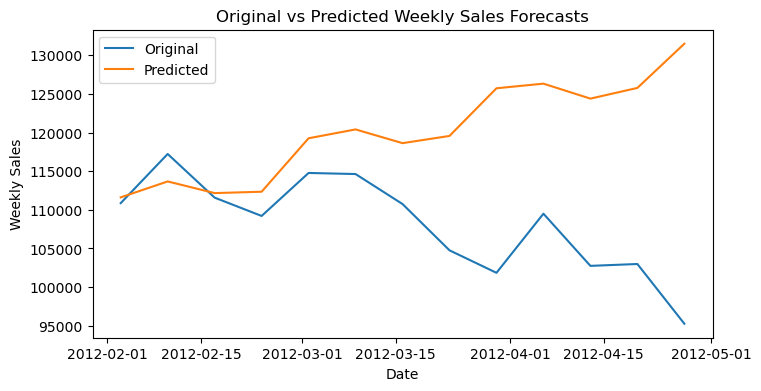

In [90]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_sarimax_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

#### PROPHET MODEL -Without Exogeneous

In [60]:
def fit_prophet_model(df):
    """
    This function fits PROPHET model
    """
    df = df.sort_values(by='Date')
    df = df[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
    model = Prophet()
    model.fit(df)
    return model

In [61]:
def train_prophet_model(df):
    """
    This function trains every series of the dataframe.
    """
    models_dict = {}
    for store_no in df.Store.unique():
        df_store = df[df.Store == store_no]
        for dept_no in df_store.Dept.unique():
            df_store_dept = df_store[df_store.Dept == dept_no]
            df_store_dept = df_store_dept.sort_values(by='Date')
            try:
                model_fit = fit_prophet_model(df_store_dept)
                models_dict[(store_no, dept_no)] = model_fit
            except Exception as e:
                print(f'Failed to fit PROPHET model for store {store_no}, category {dept_no}: {e}')
    return models_dict

In [62]:
def validate_prophet_model(df_train, df_val, models_dict, forecast_steps):
    predicted_prophet_df = pd.DataFrame()
    for store_no in df_train.Store.unique():
        df_store = df_train[df_train.Store == store_no]
        for dept_no in df_store.Dept.unique():
            model = models_dict[(store_no, dept_no)]
            future = model.make_future_dataframe(periods=forecast_steps, freq='7D')
            forecast = model.predict(future)
            forecast = forecast[['ds', 'yhat']]
            forecast['Store'] = store_no
            forecast['Dept'] = dept_no
            predicted_prophet_df  = pd.concat([predicted_prophet_df, forecast], ignore_index=False)
    predicted_prophet_df = predicted_prophet_df.reset_index()
    predicted_prophet_df = predicted_prophet_df.rename(columns={'ds': 'Date', 'yhat': 'Weekly_Sales_Predicted'})
    predicted_prophet_df = predicted_prophet_df.reset_index(drop=True)
    predicted_prophet_df = predicted_prophet_df.drop('index', axis=1)

    # merge the predicted forecast with df_val
    df_merged_predicted_sales = pd.merge(df_val, predicted_prophet_df, on=['Store', 'Dept', 'Date'], how='left')
    return df_merged_predicted_sales

In [63]:
prophet_trained_models_dict = train_prophet_model(df_train)
validation_forecasted_prophet_df = validate_prophet_model(df_train, df_val, prophet_trained_models_dict, forecast_steps=13)
mape_score_prophet_val = round(mean_absolute_percentage_error(validation_forecasted_prophet_df), 4)
print(f"Validation Score for PROPHET model is {mape_score_prophet_val}")

12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:00 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:00 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:00 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1]

Validation Score for PROPHET model is 0.452


In [64]:
prophet_trained_models_dict = train_prophet_model(df_train_val)
test_forecasted_prophet_df = validate_prophet_model(df_train_val, df_test, prophet_trained_models_dict, forecast_steps=13)
mape_score_prophet_test = round(mean_absolute_percentage_error(test_forecasted_prophet_df), 4)
print(f"Test Score for PROPHET model is {mape_score_prophet_test}")

12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:31 - cmdstanpy - INFO - Chain [1] done processing
12:21:31 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:32 - cmdstanpy - INFO - Chain [1] start processing
12:21:32 - cmdstanpy - INFO - Chain [1] done processing
12:21:33 - cmdstanpy - INFO - Chain [1] start processing
12:21:33 - cmdstanpy - INFO - Chain [1]

Test Score for PROPHET model is 23.2319


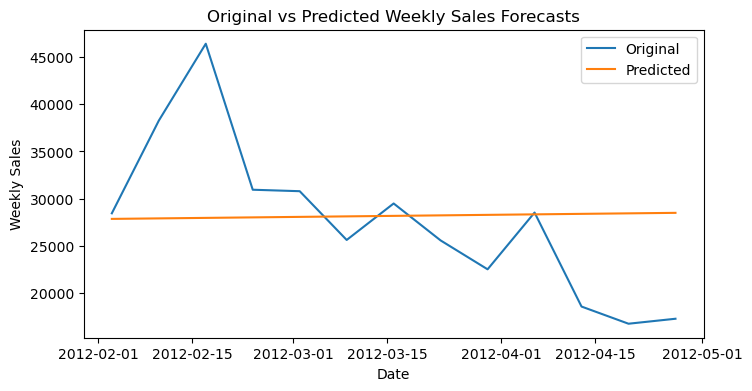

In [97]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_df, 1, 5)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

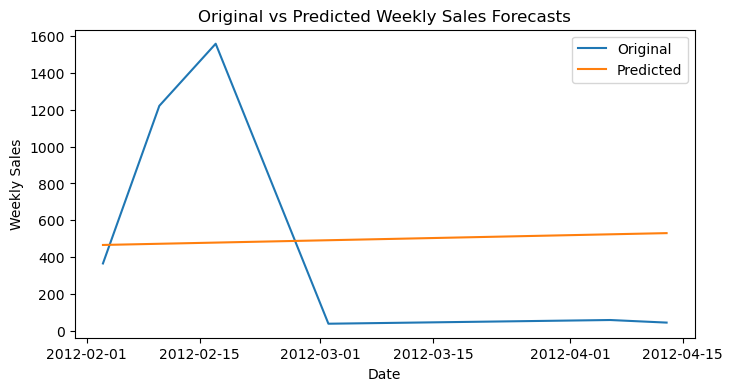

In [96]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_df, 2, 99)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

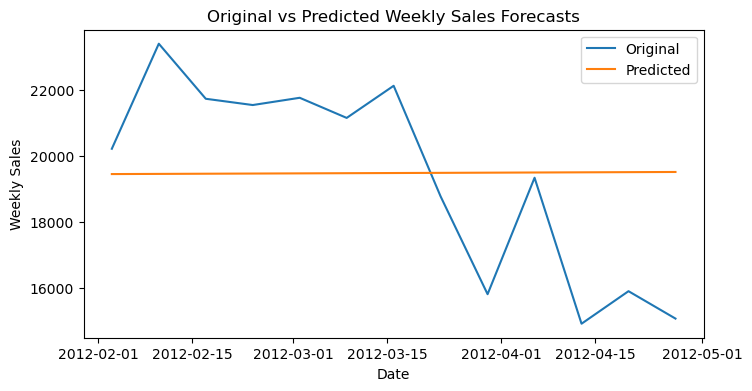

In [95]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_df, 4, 22)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

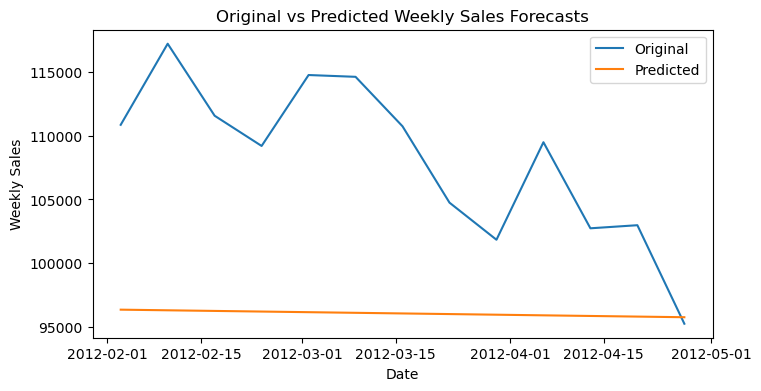

In [94]:
filtered_data_for_forecast_visualization = filter_dataframe(test_forecasted_prophet_df, 5, 40)
plot_original_and_predicted_data(filtered_data_for_forecast_visualization)

In [65]:
table.append_row(["PROPHET", "0.452", "23.2319"])
print(table)

+------------+-----------------+-----------+
| Model Name | Validation MAPE | Test MAPE |
+------------+-----------------+-----------+
|   ARIMA    |      0.381      |   4.772   |
+------------+-----------------+-----------+
|  SARIMAX   |      0.417      |  12.102   |
+------------+-----------------+-----------+
|  PROPHET   |      0.452      |  23.232   |
+------------+-----------------+-----------+


## Conclusion:
Out of these models without exegeneous variables ARIMA models works the best because both validation and test MAPE scoress are lesser compared to other models.